In [1]:
%load_ext autoreload
%matplotlib inline

%autoreload 2

# %load_ext watermark
# %watermark -v -n -m -p numpy,scipy,sklearn,pandas,tensorflow,keras


In [10]:
from data.preprocess import PreProcessor

data = PreProcessor(config=PreProcessor.DEFAULT_CONFIG,
                    data_dir='data/raw/r252-corpus-features/org/elasticsearch/action/')

vocab = data.metadata['token_vocab']
processed = data.get_tensorise_data()


In [11]:
import numpy as np
from tensorflow.python import keras
from tensorflow.python.keras import layers

from models.cnn_attention import ConvAttention

embedding_dim = 128
vocabulary_size = len(vocab) + 2
max_chunk_length = data.config['max_chunk_length']
code_snippet = processed['body_tokens']
label_name = np.expand_dims(processed['name_tokens'], 2)
# label_name = keras.utils.to_categorical(processed['name_tokens'], num_classes=vocabulary_size)
print("Vocab Size: {} Code snippet len: {} label_name len: {}".format(vocabulary_size, len(code_snippet),
                                                                      len(label_name)))

# TODO make the input a json file and parse it
batch_size = 1
k1 = 8
k2 = 8
w1 = 24
w2 = 29
w3 = 10
dropout_rate = 0.5

# Optimised hyperparameter are reported in page 5 of the paper

# define layers
main_input = layers.Input(shape=(max_chunk_length,),
                          batch_size=batch_size,
                          dtype='int32', name='main_input')

cnn_layer = ConvAttention(vocabulary_size=vocabulary_size,
                          embedding_dim=embedding_dim,
                          max_chunk_length=max_chunk_length,
                          k1=k1,
                          k2=k2,
                          w1=w1,
                          w2=w2,
                          w3=w3,
                          dropout_rate=dropout_rate)

optimizer = keras.optimizers.Nadam()  # RMSprop with Nesterov momentum
loss_func = keras.losses.sparse_categorical_crossentropy

# define execution
cnn_output = cnn_layer(main_input)
model = keras.Model(inputs=[main_input], outputs=cnn_output)
model.compile(optimizer=optimizer,
              loss=loss_func,
              metrics=['accuracy'])
# fit the model
tbCallBack = keras.callbacks.TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)

history = model.fit(code_snippet,
                    label_name,
                    epochs=5,
                    verbose=2,
                    batch_size=batch_size,
                    callbacks=[tbCallBack],
                    validation_split=0.2)


Vocab Size: 1403 Code snippet len: 1391 label_name len: 1391
ConvAttention: Tokens shape = (1, 100, 128), h_t shape = (1, 8)
AttentionFeatures: C shape = (1, 100, 128), h_t shape = (1, 8)
AttentionFeatures: L_1 shape = (1, 100, 8)
AttentionFeatures: L_2 shape = (1, 100, 8)
AttentionFeatures: L_2 shape  after multiply = (1, 100, 8)
AttentionFeatures: L_feat shape = Tensor("conv_attention_6/attention_features_6/attention_fet_l2_norm/l2_normalize:0", shape=(1, 100, 8), dtype=float32)
ConvAttention: L_feat shape = (1, 100, 8)
AttentionWeights: l_feat shape = (1, 100, 8)


AttentionWeights: attention_weight shape = (1, 100, 1)
ConvAttention: n shape = (1, 100, 1403)


Train on 1112 samples, validate on 279 samples


Epoch 1/5


 - 68s - loss: 3.5006 - acc: 0.9199 - val_loss: 0.8712 - val_acc: 0.9518


Epoch 2/5


 - 69s - loss: 0.5636 - acc: 0.9496 - val_loss: 0.4377 - val_acc: 0.9518


Epoch 3/5


 - 70s - loss: 0.4332 - acc: 0.9496 - val_loss: 0.4054 - val_acc: 0.9518


Epoch 4/5


 - 63s - loss: 0.4165 - acc: 0.9496 - val_loss: 0.3977 - val_acc: 0.9518


Epoch 5/5


 - 59s - loss: 0.4110 - acc: 0.9496 - val_loss: 0.3950 - val_acc: 0.9518


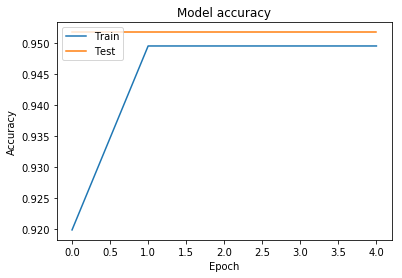

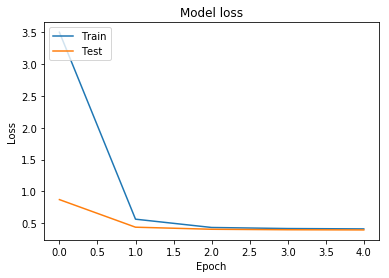

In [12]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [13]:
# # overfit and evaluate the model 
loss, accuracy = model.evaluate(code_snippet, label_name, batch_size=1, verbose=0)
print('Accuracy: {}'.format(accuracy * 100))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (1, 100)                  0         
_________________________________________________________________
conv_attention_6 (ConvAttent (1, 100, 1403)            212207    
Total params: 212,207
Trainable params: 212,207
Non-trainable params: 0
_________________________________________________________________


Accuracy: 95.0021563203621


In [14]:
# translate prediction

from data.utils import translate_tokenized_array_to_list_words
prediction = model.predict(code_snippet[0].reshape(1, -1))
# translate_tokenized_array_to_list_words(vocab, processed['name_tokens'][5])
# print(prediction)


In [67]:
prediction.argmax(2)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])